### **Libraries**

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

### **Set working directory to root**

In [2]:
# Set working directory to project root
if Path.cwd().name == "notebooks":
    os.chdir("..")

print(f"Working directory: {Path.cwd()}")


Working directory: d:\MLops\NetworkSecurity


### **Load the data**

In [5]:
# Display settings for pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")

In [6]:
RAW_PATH = Path("data/raw/PhiUSIIL_Phishing_URL_Dataset.csv")
OUT_DIR = Path("outputs/eda")
OUT_DIR.mkdir(parents=True, exist_ok=True)


df = pd.read_csv(RAW_PATH)
df.head()

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,3,1,0,0,0.0,18,0.581,0,0.0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,0.000000,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,2,1,0,0,0.0,9,0.391,0,0.0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.555556,55.555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,2,2,0,0,0.0,15,0.517,0,0.0,0,0,0,2,0.069,1,467,682,1,voice fm southampton,46.666667,46.666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,3,1,0,0,0.0,13,0.500,0,0.0,0,0,0,1,0.038,1,6356,26824,1,home page: seminars in fetal and neonatal medi...,0.000000,0.000000,0,1,1,0,0,0,1,12,0,1,1,1,0,0,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,3,1,0,0,0.0,20,0.606,0,0.0,0,0,0,1,0.030,1,6089,28404,1,fundaciÃ³n rewilding argentina,100.000000,100.000000,0,1,1,1,1,1,0,2,0,1,1,1,0,1,1,0,1,244,15,34,72,1,85,1


### **Data investigation**

In [7]:
print(f"\n{'=' * 60}")
print(f"Dataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print(f"{'=' * 60}")

print("\n" + "=" * 60)
print("COLUMN OVERVIEW")
print("=" * 60)

# Get column info
col_info = pd.DataFrame(
    {
        "Column": df.columns,
        "Dtype": df.dtypes.values,
        "Non-Null": df.notna().sum().values,
        "Null%": (df.isna().sum() / len(df) * 100).round(2).values,
        "Unique": df.nunique().values,
    }
)

print(col_info.to_string(index=False))

# Identify label column
label_col = "label"


print(f"\n Label column : '{label_col}'")
print(f"\n Label distribution:")
print(df[label_col].value_counts().to_frame("count"))
print(
    f"\n Class balance: {df[label_col].value_counts(normalize=True).round(3).to_dict()}"
)



Dataset Shape: (235795, 55)
Rows: 235,795 | Columns: 55

COLUMN OVERVIEW
                    Column   Dtype  Non-Null  Null%  Unique
                       URL  object    235795    0.0  235370
                 URLLength   int64    235795    0.0     482
                    Domain  object    235795    0.0  220086
              DomainLength   int64    235795    0.0     101
                IsDomainIP   int64    235795    0.0       2
                       TLD  object    235795    0.0     695
        URLSimilarityIndex float64    235795    0.0   36360
      CharContinuationRate float64    235795    0.0     898
         TLDLegitimateProb float64    235795    0.0     465
               URLCharProb float64    235795    0.0  227421
                 TLDLength   int64    235795    0.0      12
             NoOfSubDomain   int64    235795    0.0      10
            HasObfuscation   int64    235795    0.0       2
        NoOfObfuscatedChar   int64    235795    0.0      20
          ObfuscationRatio

- The dataset has no nulls and a ~57/43 split (reasonably balanced), so won't need aggressive SMOTE/resampling—just class weighting in the model."

### **Duplicates**

In [8]:
print("\n" + "=" * 60)
print("DUPLICATE URL INVESTIGATION")
print("=" * 60)

# 1. Check for exact URL duplicates
print("\n1. EXACT URL DUPLICATES")
print("-" * 60)

total_urls = len(df)
unique_urls = df["URL"].nunique()
duplicates = total_urls - unique_urls

print(f"Total rows: {total_urls:,}")
print(f"Unique URLs: {unique_urls:,}")
print(f"Duplicate URLs: {duplicates:,} ({duplicates / total_urls * 100:.2f}%)")

if duplicates > 0:
    # Find which URLs are duplicated
    url_counts = df["URL"].value_counts()
    duplicated_urls = url_counts[url_counts > 1]

    print(f"\nNumber of URLs that appear multiple times: {len(duplicated_urls):,}")
    print(f"Max occurrences of a single URL: {duplicated_urls.max()}")

    # Show top duplicates
    print("\nTop 10 most duplicated URLs:")
    for url, count in duplicated_urls.head(10).items():
        print(f"  {count}x: {url[:15]}...")

    # Check if duplicates have same label
    print("\n" + "-" * 60)
    print("2. LABEL CONSISTENCY FOR DUPLICATES")
    print("-" * 60)

    inconsistent = []
    for url in duplicated_urls.index[:100]:  # Check first 100 duplicated URLs
        labels = df[df["URL"] == url]["label"].unique()
        if len(labels) > 1:
            inconsistent.append((url, labels))

    if inconsistent:
        print(f"  Found {len(inconsistent)} URLs with INCONSISTENT labels!")
        print("\nExamples:")
        for url, labels in inconsistent[:5]:
            print(f"  {url}")
            print(f"    Labels: {labels} (appears as both phish and legit!)")
    else:
        print(" All duplicated URLs have consistent labels")

else:
    print("\n No duplicate URLs found!")



DUPLICATE URL INVESTIGATION

1. EXACT URL DUPLICATES
------------------------------------------------------------
Total rows: 235,795
Unique URLs: 235,370
Duplicate URLs: 425 (0.18%)

Number of URLs that appear multiple times: 425
Max occurrences of a single URL: 2

Top 10 most duplicated URLs:
  2x: https://disclos...
  2x: https://barland...
  2x: http://app-bata...
  2x: https://fleek.i...
  2x: https://sucursa...
  2x: https://owashdy...
  2x: https://objects...
  2x: http://34.149.1...
  2x: https://mn-mett...
  2x: https://danielc...

------------------------------------------------------------
2. LABEL CONSISTENCY FOR DUPLICATES
------------------------------------------------------------
 All duplicated URLs have consistent labels


- Duplicate URLs are 425 (0.18%) negligable data loss and all duplicated URLs have consistent labels, so to prevent leakage meaning for a url to be both in train and test we need to drop it.

### **Drop Duplicates**

In [9]:
print("=" * 60)
print("REMOVING DUPLICATE URLs")
print("=" * 60)

print(f"\nBefore deduplication:")
print(f"  Total rows: {len(df):,}")
print(f"  Unique URLs: {df['URL'].nunique():,}")

df_deduped = df.drop_duplicates(subset=["URL"], keep="first").reset_index(drop=True)

print(f"\nAfter deduplication:")
print(f"  Total rows: {len(df_deduped):,}")
print(f"  Unique URLs: {df_deduped['URL'].nunique():,}")
print(f"  Removed: {len(df) - len(df_deduped):,} duplicate rows")

print(f"\nLabel distribution before:")
print(df["label"].value_counts())
print(f"\nLabel distribution after:")
print(df_deduped["label"].value_counts())

df = df_deduped.copy()

print("\n" + "=" * 60)
print("FINAL DATA SUMMARY")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Unique URLs: {df['URL'].nunique():,}")
print(f"No duplicates: {df['URL'].nunique() == len(df)}")
print(f"No missing values: {df.isna().sum().sum() == 0}")
print(f"Label balance: {dict(df['label'].value_counts(normalize=True).round(3))}")
print("\nReady for feature visualization")


REMOVING DUPLICATE URLs

Before deduplication:
  Total rows: 235,795
  Unique URLs: 235,370

After deduplication:
  Total rows: 235,370
  Unique URLs: 235,370
  Removed: 425 duplicate rows

Label distribution before:
label
1    134850
0    100945
Name: count, dtype: int64

Label distribution after:
label
1    134850
0    100520
Name: count, dtype: int64

FINAL DATA SUMMARY
Shape: (235370, 55)
Unique URLs: 235,370
No duplicates: True
No missing values: True
Label balance: {1: 0.573, 0: 0.427}

Ready for feature visualization


### **Check for near-duplicates (case-insensitive, whitespace)**

In [10]:
# 2. Check for near-duplicates (case-insensitive, whitespace)
print("\n" + "=" * 60)
print("3. NEAR-DUPLICATE CHECK (case-insensitive)")
print("=" * 60)

df["url_normalized"] = df["URL"].str.lower().str.strip()
normalized_unique = df["url_normalized"].nunique()
near_duplicates = len(df) - normalized_unique

print(f"Unique URLs (normalized): {normalized_unique:,}")
print(f"Near-duplicates (case/whitespace): {near_duplicates:,}")

if near_duplicates > duplicates:
    print(f"\n  Found {near_duplicates - duplicates} additional near-duplicates")
    # Show examples
    case_dups = df[
        df.duplicated(subset=["url_normalized"], keep=False)
        & ~df.duplicated(subset=["URL"], keep=False)
    ]
    if not case_dups.empty:
        inconsistent = []
        print("\nExamples of case-sensitive duplicates:")
        for url in case_dups["URL"].head(5):
            print(f"  {url}")

        if inconsistent:
            print(f"  Found {len(inconsistent)} URLs with INCONSISTENT labels!")
            print("\nExamples:")
            for url, labels in inconsistent[:5]:
                print(f"  {url}")
                print(f"    Labels: {labels} (appears as both phish and legit!)")
        else:
            print(" All case-sensitive duplicated URLs have consistent labels")



3. NEAR-DUPLICATE CHECK (case-insensitive)
Unique URLs (normalized): 235,370
Near-duplicates (case/whitespace): 0


### **Sample URLs and Test Extraction**

- For availability and reliability, URL-only features are always accessible without needing to fetch the webpage. Many phishing sites go down quickly, have anti-scraping protections, or block automated requests. With URL-only, we avoid those failure modes entirely.

In [11]:
print("=" * 60)
print("COMPLETE URL-ONLY FEATURE VERIFICATION")
print("=" * 60)

url_structure_candidates = [
    "URLLength",
    "DomainLength",
    "IsDomainIP",
    "TLD",
    "TLDLength",
    "NoOfSubDomain",
    "IsHTTPS",
    "Domain",
]

url_character_candidates = [
    "NoOfLettersInURL",
    "LetterRatioInURL",
    "NoOfDegitsInURL",
    "DegitRatioInURL",
    "NoOfEqualsInURL",
    "NoOfQMarkInURL",
    "NoOfAmpersandInURL",
    "NoOfOtherSpecialCharsInURL",
    "SpacialCharRatioInURL",
    "HasObfuscation",
    "NoOfObfuscatedChar",
    "ObfuscationRatio",
    "CharContinuationRate",
    "URLCharProb",
    "TLDLegitimateProb",
]

behavioral_candidates = ["Bank", "Pay", "Crypto"]

page_content_to_exclude = [
    "URLSimilarityIndex",
    "LargestLineLength",
    "DomainTitleMatchScore",
    "URLTitleMatchScore",
    "NoOfURLRedirect",
    "HasDescription",
    "LineOfCode",
    "HasTitle",
    "Title",
    "HasFavicon",
    "Robots",
    "IsResponsive",
    "NoOfSelfRedirect",
    "HasDescription",
    "NoOfPopup",
    "NoOfiFrame",
    "HasExternalFormSubmit",
    "HasSocialNet",
    "HasSubmitButton",
    "HasHiddenFields",
    "HasPasswordField",
    "HasCopyrightInfo",
    "NoOfImage",
    "NoOfCSS",
    "NoOfJS",
    "NoOfSelfRef",
    "NoOfEmptyRef",
    "NoOfExternalRef",
]

all_url_only_candidates = (
    url_structure_candidates + url_character_candidates + behavioral_candidates
)

print(f"URL-only candidates: {len(all_url_only_candidates)}")

available_url_only = [f for f in all_url_only_candidates if f in df.columns]
missing = [f for f in all_url_only_candidates if f not in df.columns]

print(f"\nAvailable in dataset: {len(available_url_only)}")
print(f"Missing from dataset: {len(missing)}")

if missing:
    print(f"\nMissing features:")
    for f in missing:
        print(f"  - {f}")

print(f"\n" + "=" * 60)
print(f"FINAL URL-ONLY FEATURE LIST ({len(available_url_only)} features)")
print("=" * 60)

for i, f in enumerate(available_url_only, 1):
    print(f"{i:2d}. {f}")

print(f"\n" + "=" * 60)
print("VERIFY NO PAGE-CONTENT FEATURES INCLUDED")
print("=" * 60)

contamination = [f for f in available_url_only if f in page_content_to_exclude]
if contamination:
    print(
        f"WARNING: Found {len(contamination)} page-content features in URL-only list:"
    )
    for f in contamination:
        print(f"  - {f}")
else:
    print("Clean - no page-content features included")

available_url_only_clean = [
    f for f in available_url_only if f not in page_content_to_exclude
]
print(f"\nFinal clean URL-only features: {len(available_url_only_clean)}")


COMPLETE URL-ONLY FEATURE VERIFICATION
URL-only candidates: 26

Available in dataset: 26
Missing from dataset: 0

FINAL URL-ONLY FEATURE LIST (26 features)
 1. URLLength
 2. DomainLength
 3. IsDomainIP
 4. TLD
 5. TLDLength
 6. NoOfSubDomain
 7. IsHTTPS
 8. Domain
 9. NoOfLettersInURL
10. LetterRatioInURL
11. NoOfDegitsInURL
12. DegitRatioInURL
13. NoOfEqualsInURL
14. NoOfQMarkInURL
15. NoOfAmpersandInURL
16. NoOfOtherSpecialCharsInURL
17. SpacialCharRatioInURL
18. HasObfuscation
19. NoOfObfuscatedChar
20. ObfuscationRatio
21. CharContinuationRate
22. URLCharProb
23. TLDLegitimateProb
24. Bank
25. Pay
26. Crypto

VERIFY NO PAGE-CONTENT FEATURES INCLUDED
Clean - no page-content features included

Final clean URL-only features: 26


In [12]:
# Filter the DataFrame to only include features in available_url_only_clean
filtered_df = df[available_url_only_clean]

# Create the col_info DataFrame
col_info_url = pd.DataFrame(
    {
        "Column": filtered_df.columns,
        "Dtype": filtered_df.dtypes.values,
        "Non-Null": filtered_df.notna().sum().values,
        "Null%": (filtered_df.isna().sum() / len(filtered_df) * 100).round(2).values,
        "Unique": filtered_df.nunique().values,
    }
)

# Print the DataFrame
print(col_info_url.to_string(index=False))


                    Column   Dtype  Non-Null  Null%  Unique
                 URLLength   int64    235370    0.0     482
              DomainLength   int64    235370    0.0     101
                IsDomainIP   int64    235370    0.0       2
                       TLD  object    235370    0.0     695
                 TLDLength   int64    235370    0.0      12
             NoOfSubDomain   int64    235370    0.0      10
                   IsHTTPS   int64    235370    0.0       2
                    Domain  object    235370    0.0  220086
          NoOfLettersInURL   int64    235370    0.0     421
          LetterRatioInURL float64    235370    0.0     709
           NoOfDegitsInURL   int64    235370    0.0     182
           DegitRatioInURL float64    235370    0.0     575
           NoOfEqualsInURL   int64    235370    0.0      25
            NoOfQMarkInURL   int64    235370    0.0       5
        NoOfAmpersandInURL   int64    235370    0.0      31
NoOfOtherSpecialCharsInURL   int64    23

### **Visualisation**

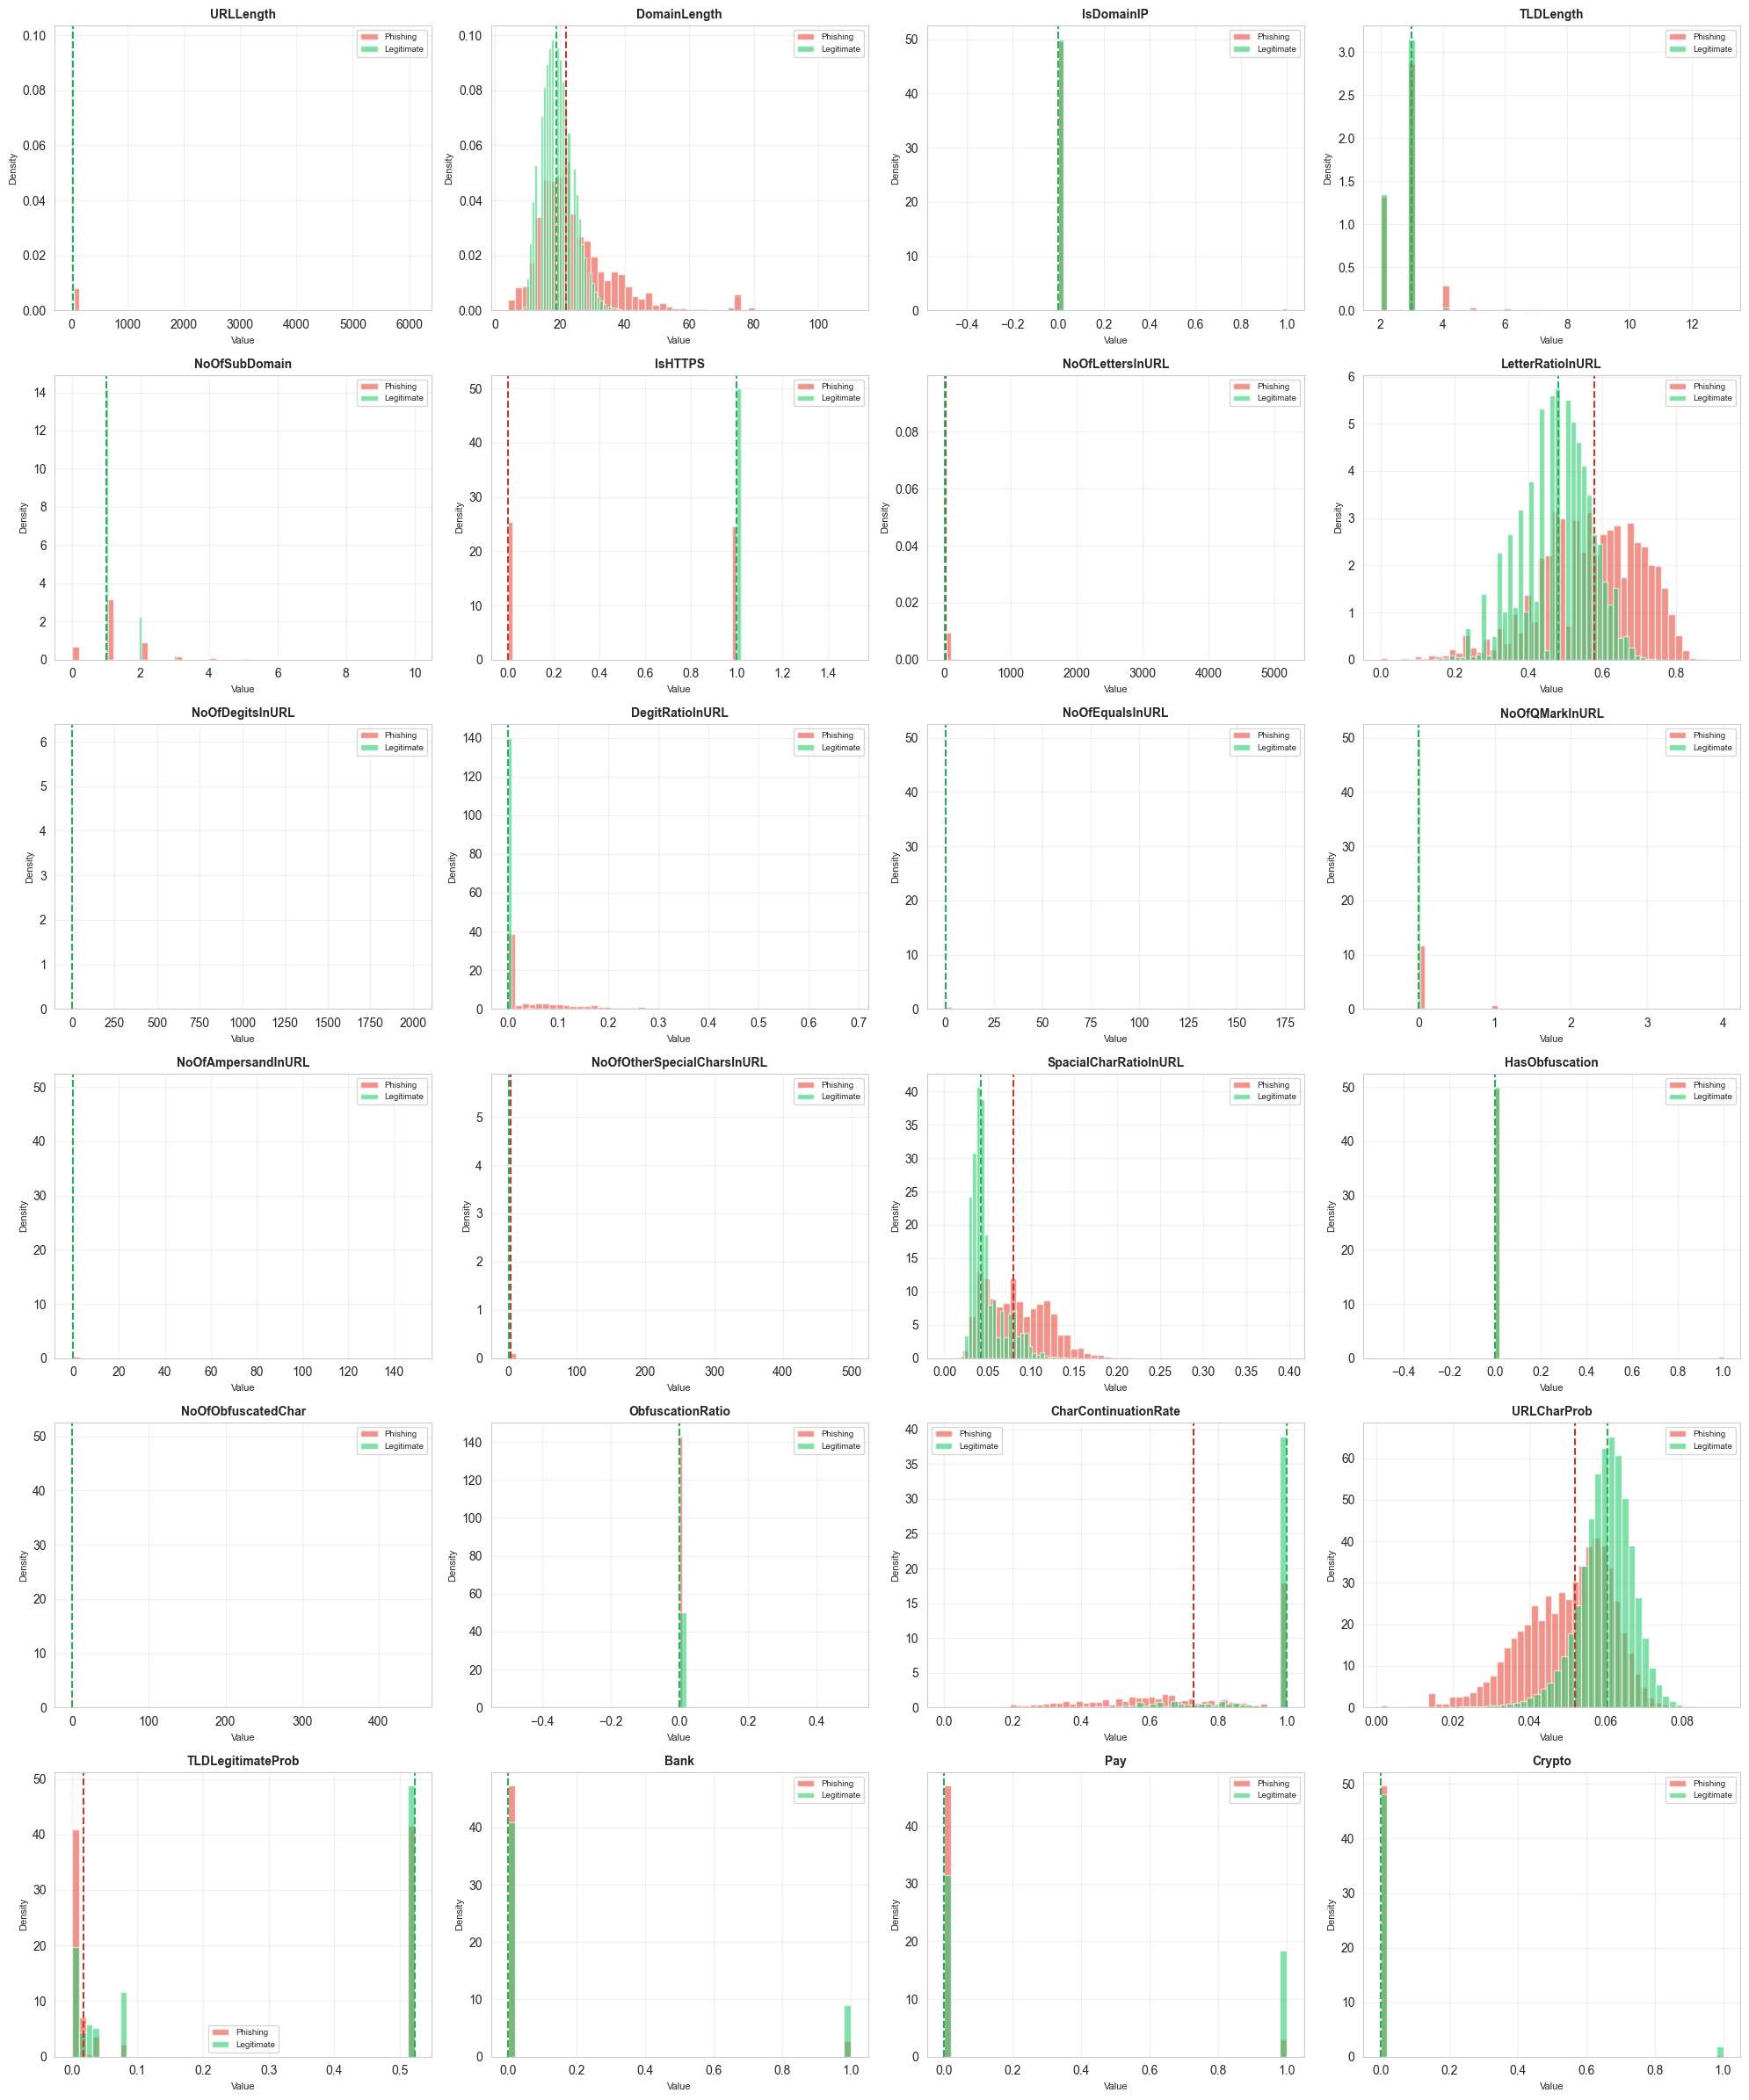

Saved: outputs/eda/all_url_only_features_distribution.png

FEATURE SEPARATION ANALYSIS (ALL 25 URL-ONLY FEATURES)


In [13]:
url_only_features = [
    "URLLength",
    "DomainLength",
    "IsDomainIP",
    "TLDLength",
    "NoOfSubDomain",
    "IsHTTPS",
    "NoOfLettersInURL",
    "LetterRatioInURL",
    "NoOfDegitsInURL",
    "DegitRatioInURL",
    "NoOfEqualsInURL",
    "NoOfQMarkInURL",
    "NoOfAmpersandInURL",
    "NoOfOtherSpecialCharsInURL",
    "SpacialCharRatioInURL",
    "HasObfuscation",
    "NoOfObfuscatedChar",
    "ObfuscationRatio",
    "CharContinuationRate",
    "URLCharProb",
    "TLDLegitimateProb",
    "Bank",
    "Pay",
    "Crypto",
]

n_features = len(url_only_features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.ravel()

for idx, feature in enumerate(url_only_features):
    ax = axes[idx]

    phish = df[df["label"] == 0][feature]
    legit = df[df["label"] == 1][feature]

    ax.hist(phish, bins=50, alpha=0.6, label="Phishing", color="#e74c3c", density=True)
    ax.hist(
        legit, bins=50, alpha=0.6, label="Legitimate", color="#2ecc71", density=True
    )

    ax.axvline(phish.median(), color="#c0392b", linestyle="--", linewidth=1.5)
    ax.axvline(legit.median(), color="#27ae60", linestyle="--", linewidth=1.5)

    ax.set_title(f"{feature}", fontsize=10, fontweight="bold")
    ax.set_xlabel("Value", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(
    "outputs/eda/all_url_only_features_distribution.png", dpi=150, bbox_inches="tight"
)
plt.show()

print("Saved: outputs/eda/all_url_only_features_distribution.png")

print("\n" + "=" * 60)
print("FEATURE SEPARATION ANALYSIS (ALL 25 URL-ONLY FEATURES)")
print("=" * 60)


### **Separation Score Measures**

In [14]:
separation_scores = []

for feature in url_only_features:
    phish = df[df["label"] == 0][feature]
    legit = df[df["label"] == 1][feature]

    phish_med = phish.median()
    legit_med = legit.median()
    phish_mean = phish.mean()
    legit_mean = legit.mean()

    pooled_std = np.sqrt((phish.std() ** 2 + legit.std() ** 2) / 2)
    separation = abs(phish_med - legit_med) / (pooled_std + 1e-10)  # Avoid div by zero

    separation_scores.append(
        {
            "feature": feature,
            "phish_median": phish_med,
            "legit_median": legit_med,
            "phish_mean": phish_mean,
            "legit_mean": legit_mean,
            "separation": separation,
        }
    )

sep_df = pd.DataFrame(separation_scores).sort_values("separation", ascending=False)

print("\nTop 15 features by separation score:")
print(sep_df.head(15).to_string(index=False))

print("\n" + "=" * 60)
print("BOTTOM 10 FEATURES (WEAKEST SEPARATION)")
print("=" * 60)
print(sep_df.tail(10).to_string(index=False))

sep_df.to_csv("outputs/eda/url_only_feature_separation_scores.csv", index=False)
print("\nSaved: outputs/eda/url_only_feature_separation_scores.csv")



Top 15 features by separation score:
                   feature  phish_median  legit_median  phish_mean  legit_mean  separation
                   IsHTTPS      0.000000      1.000000    0.491226    1.000000    2.828849
         TLDLegitimateProb      0.018013      0.522907    0.232167    0.281625    2.011652
      CharContinuationRate      0.727273      1.000000    0.728818    0.933176    1.371961
     SpacialCharRatioInURL      0.080000      0.042000    0.083229    0.048356    1.330241
               URLCharProb      0.052030      0.060628    0.050005    0.060050    0.889486
          LetterRatioInURL      0.577000      0.480000    0.568128    0.476705    0.824554
NoOfOtherSpecialCharsInURL      3.000000      1.000000    3.799771    1.244835    0.562204
              DomainLength     22.000000     19.000000   24.444150   19.228610    0.323893
          NoOfLettersInURL     20.000000     13.000000   28.088669   12.933059    0.230573
                 URLLength     34.000000     26.0000

- From this analysis, we learned that not all URL features are created equal—some are powerful discriminators (like `HTTPS` and `TLD legitimacy`), while many are essentially useless for classification. The high separation of HTTPS-related features aligns with real-world phishing tactics, where attackers avoid secure connections. Conversely, the zero-separation features (like `query parameter` counts) suggest they're either uniformly rare or not indicative of malicious intent.

- Therefore, this data strongly recommends prioritizing the top separators (e.g., IsHTTPS, TLDLegitimateProb) and avoiding the bottom ones.

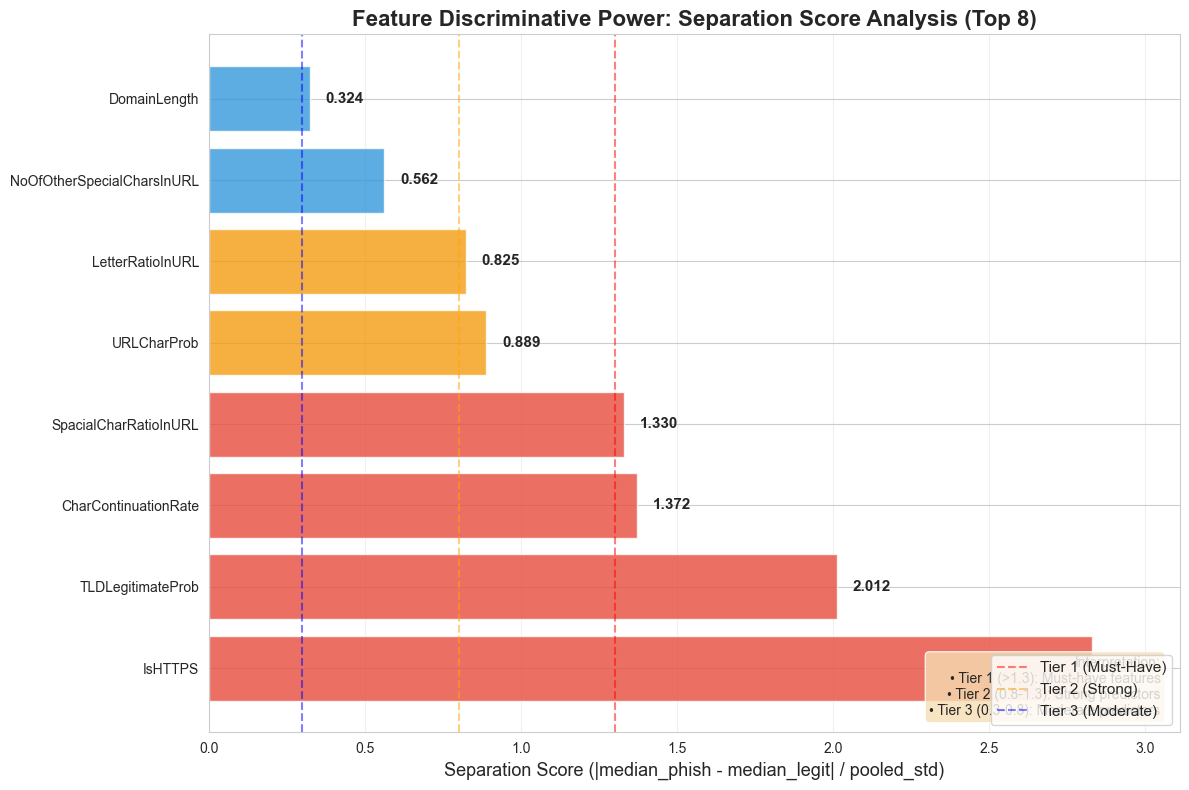

✅ Generated: outputs\eda\feature_separation_scores_top8.png


{'IsHTTPS': 2.8288486724778688,
 'TLDLegitimateProb': 2.011651981363957,
 'CharContinuationRate': 1.3719612367555731,
 'SpacialCharRatioInURL': 1.3302409367021415,
 'URLCharProb': 0.8894858429838537,
 'LetterRatioInURL': 0.8245540546549268,
 'NoOfOtherSpecialCharsInURL': 0.5622037629430091,
 'DomainLength': 0.323892623032157}

In [16]:
def plot_feature_separation_scores(sep_df, top_n=None, feature_filter=None):
    """
    Horizontal bar chart showing separation scores for features.

    Args:
        sep_df: DataFrame with 'feature' and 'separation' columns
        top_n: If specified, show only top N features by separation score
        feature_filter: If specified, list of feature names to include
    """
    # Create a copy to avoid modifying original
    df = sep_df.copy()

    # Filter to specific features if requested
    if feature_filter:
        df = df[df["feature"].isin(feature_filter)]

    # Sort by separation score (descending) and take top_n if specified
    df = df.sort_values("separation", ascending=False)
    if top_n:
        df = df.head(top_n)

    # Create features dict from DataFrame
    features = dict(zip(df["feature"], df["separation"]))

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define tier colors based on separation scores
    colors = []
    for score in features.values():
        if score > 1.3:
            colors.append("#e74c3c")  # Tier 1 (red)
        elif score > 0.8:
            colors.append("#f39c12")  # Tier 2 (orange)
        elif score > 0.3:
            colors.append("#3498db")  # Tier 3 (blue)
        else:
            colors.append("#95a5a6")  # Tier 4 (gray)

    # Create horizontal bar chart
    bars = ax.barh(
        list(features.keys()), list(features.values()), color=colors, alpha=0.8
    )

    # Add value labels on bars
    for i, (feature, score) in enumerate(features.items()):
        ax.text(
            score + 0.05, i, f"{score:.3f}", va="center", fontsize=11, fontweight="bold"
        )

    # Add tier threshold lines
    ax.axvline(
        x=1.3,
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.5,
        label="Tier 1 (Must-Have)",
    )
    ax.axvline(
        x=0.8,
        color="orange",
        linestyle="--",
        linewidth=1.5,
        alpha=0.5,
        label="Tier 2 (Strong)",
    )
    ax.axvline(
        x=0.3,
        color="blue",
        linestyle="--",
        linewidth=1.5,
        alpha=0.5,
        label="Tier 3 (Moderate)",
    )

    # Labels and formatting
    ax.set_xlabel(
        "Separation Score (|median_phish - median_legit| / pooled_std)", fontsize=13
    )
    title = "Feature Discriminative Power: Separation Score Analysis"
    if top_n:
        title += f" (Top {top_n})"
    if feature_filter:
        title += f" ({len(feature_filter)} Selected Features)"
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.legend(loc="lower right", fontsize=11, frameon=True, fancybox=True)
    ax.grid(axis="x", alpha=0.3)
    ax.set_xlim([0, max(features.values()) * 1.1])  # Dynamic x-limit

    # Add text box with interpretation
    textstr = (
        "Interpretation:\n"
        "• Tier 1 (>1.3): Must-have features\n"
        "• Tier 2 (0.8-1.3): Strong predictors\n"
        "• Tier 3 (0.3-0.8): Moderate predictors"
    )
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
    ax.text(
        0.98,
        0.02,
        textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

    plt.tight_layout()
    output_file = (
        OUT_DIR / f"feature_separation_scores{'_top' + str(top_n) if top_n else ''}.png"
    )
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()  # Display in notebook
    plt.close()
    print(f"✅ Generated: {output_file}")

    return features  # Return the features dict for further use


plot_feature_separation_scores(sep_df, top_n=8)


### **Categorical Feature Analysis**

- **TLD**
Key Discoveries
1. *High-Risk TLDs (phish_rate > 80%)*

    - `.top` - 99.9% phishing (2,325 out of 2,327)
    - `.dev` - 98.6% phishing (2,289 out of 2,322)
    - `.app` - 97.8% phishing (6,327 out of 6,467)
    - `.co` - 91.5% phishing (4,950 out of 5,408)
    - `.io` - 89.7% phishing (3,742 out of 4,174)

These 5 TLDs alone account for `19,633` phishing URLs!

2. *TLDLegitimateProb IS Capturing This*
Looking at the comparison:

    - `.app` - Actual phish: 97.8% | TLDLegitimateProb: 0.002 (correctly identifies as suspicious)
    - `.co` - Actual phish: 91.5% | TLDLegitimateProb: 0.006 (correctly identifies as suspicious)
    - `.org` - Actual phish: 12.1% | TLDLegitimateProb: 0.080 (correctly identifies as legitimate)
    - `.edu` - Actual phish: 0.3% | TLDLegitimateProb: not shown, but likely high

Conclusion: `TLDLegitimateProb` is working as intended!

In [18]:
print("=" * 60)
print("CATEGORICAL FEATURE ANALYSIS: TLD")
print("=" * 60)

print(f"\nTLD column stats:")
print(f"  Unique TLDs: {df['TLD'].nunique()}")
print(f"  Most common TLD: {df['TLD'].value_counts().index[0]}")
print(f"  Null TLDs: {df['TLD'].isna().sum()}")

print("\n" + "=" * 60)
print("TOP 20 TLDs BY FREQUENCY")
print("=" * 60)

tld_counts = df["TLD"].value_counts().head(20)
print(tld_counts)


print("\n" + "=" * 60)
print("BOTTOM 20 TLDs BY FREQUENCY")
print("=" * 60)

tld_counts_bottom = df["TLD"].value_counts().tail(20)
print(tld_counts_bottom)

print("\n" + "=" * 60)
print("TLD PHISHING RATES (TOP 20)")
print("=" * 60)

tld_phish_rate = []
for tld in tld_counts.index:
    tld_subset = df[df["TLD"] == tld]
    phish_rate = (tld_subset["label"] == 0).mean()
    total_count = len(tld_subset)
    tld_phish_rate.append(
        {
            "TLD": tld,
            "total_count": total_count,
            "phish_rate": phish_rate,
            "phish_count": (tld_subset["label"] == 0).sum(),
            "legit_count": (tld_subset["label"] == 1).sum(),
        }
    )

tld_df = pd.DataFrame(tld_phish_rate).sort_values("phish_rate", ascending=False)
print(tld_df.to_string(index=False))

print("\n" + "=" * 60)
print("SUSPICIOUS TLDs (phish_rate > 0.8)")
print("=" * 60)

suspicious_tlds = tld_df[tld_df["phish_rate"] > 0.8]
print(suspicious_tlds.to_string(index=False))

print("\n" + "=" * 60)
print("COMPARISON: TLD vs TLDLegitimateProb")
print("=" * 60)

print("\nFor top 10 TLDs, compare actual phish rate vs TLDLegitimateProb:")
for tld in tld_counts.index[:10]:
    tld_subset = df[df["TLD"] == tld]
    actual_phish_rate = (tld_subset["label"] == 0).mean()
    avg_tld_prob = tld_subset["TLDLegitimateProb"].mean()

    print(f"\n  {tld}:")
    print(f"    Actual phish rate: {actual_phish_rate:.3f}")
    print(f"    Avg TLDLegitimateProb: {avg_tld_prob:.3f}")
    print(f"    Legitimate rate (1 - phish): {1 - actual_phish_rate:.3f}")


CATEGORICAL FEATURE ANALYSIS: TLD

TLD column stats:
  Unique TLDs: 695
  Most common TLD: com
  Null TLDs: 0

TOP 20 TLDs BY FREQUENCY
TLD
com     112382
org      18792
net       7076
app       6467
uk        6395
co        5408
io        4174
de        3994
ru        3870
au        2979
top       2327
dev       2322
jp        2219
it        1887
edu       1861
fr        1857
br        1841
nl        1727
ca        1614
info      1565
Name: count, dtype: int64

BOTTOM 20 TLDs BY FREQUENCY
TLD
tattoo       1
196          1
216          1
227          1
limited      1
racing       1
52           1
68:8080      1
taipei       1
crs          1
121          1
furniture    1
expert       1
citic        1
47           1
sharp        1
faith        1
243          1
makeup       1
ne           1
Name: count, dtype: int64

TLD PHISHING RATES (TOP 20)
 TLD  total_count  phish_rate  phish_count  legit_count
 top         2327    0.999141         2325            2
 dev         2322    0.985788     

- **Domain**
- Domain is TOO SPECIFIC to generalize
- Top domains are 100% one class (data leakage)
- Exclude Domain 

In [14]:
print(f"Total unique domains: {df['Domain'].nunique()}")
print(f"Total URLs: {len(df)}")
print(f"Average URLs per domain: {len(df) / df['Domain'].nunique():.2f}")

# Check if domains repeat across BOTH classes
domain_class_dist = df.groupby("Domain")["label"].apply(lambda x: x.nunique())
mixed_label_domains = (domain_class_dist > 1).sum()
print(f"Domains with BOTH phish and legit examples: {mixed_label_domains}")


Total unique domains: 220086
Total URLs: 235370
Average URLs per domain: 1.07
Domains with BOTH phish and legit examples: 54


### **Correlation heatmap to check for redundancy**

KEY INSIGHTS FROM FEATURE DISTRIBUTIONS

STRONG DISCRIMINATORS (separation > 0.8):
  IsHTTPS: 2.829
    Phish median: 0.000 | Legit median: 1.000
  TLDLegitimateProb: 2.012
    Phish median: 0.018 | Legit median: 0.523
  CharContinuationRate: 1.372
    Phish median: 0.727 | Legit median: 1.000
  SpacialCharRatioInURL: 1.330
    Phish median: 0.080 | Legit median: 0.042
  URLCharProb: 0.889
    Phish median: 0.052 | Legit median: 0.061
  LetterRatioInURL: 0.825
    Phish median: 0.577 | Legit median: 0.480

WEAK DISCRIMINATORS (separation < 0.1):
  Found 14 features with minimal separation:
    - HasObfuscation
    - Pay
    - Bank
    - ObfuscationRatio
    - NoOfObfuscatedChar
    - NoOfAmpersandInURL
    - NoOfQMarkInURL
    - NoOfEqualsInURL
    - DegitRatioInURL
    - NoOfDegitsInURL
    - NoOfSubDomain
    - TLDLength
    - IsDomainIP
    - Crypto

CORRELATION ANALYSIS


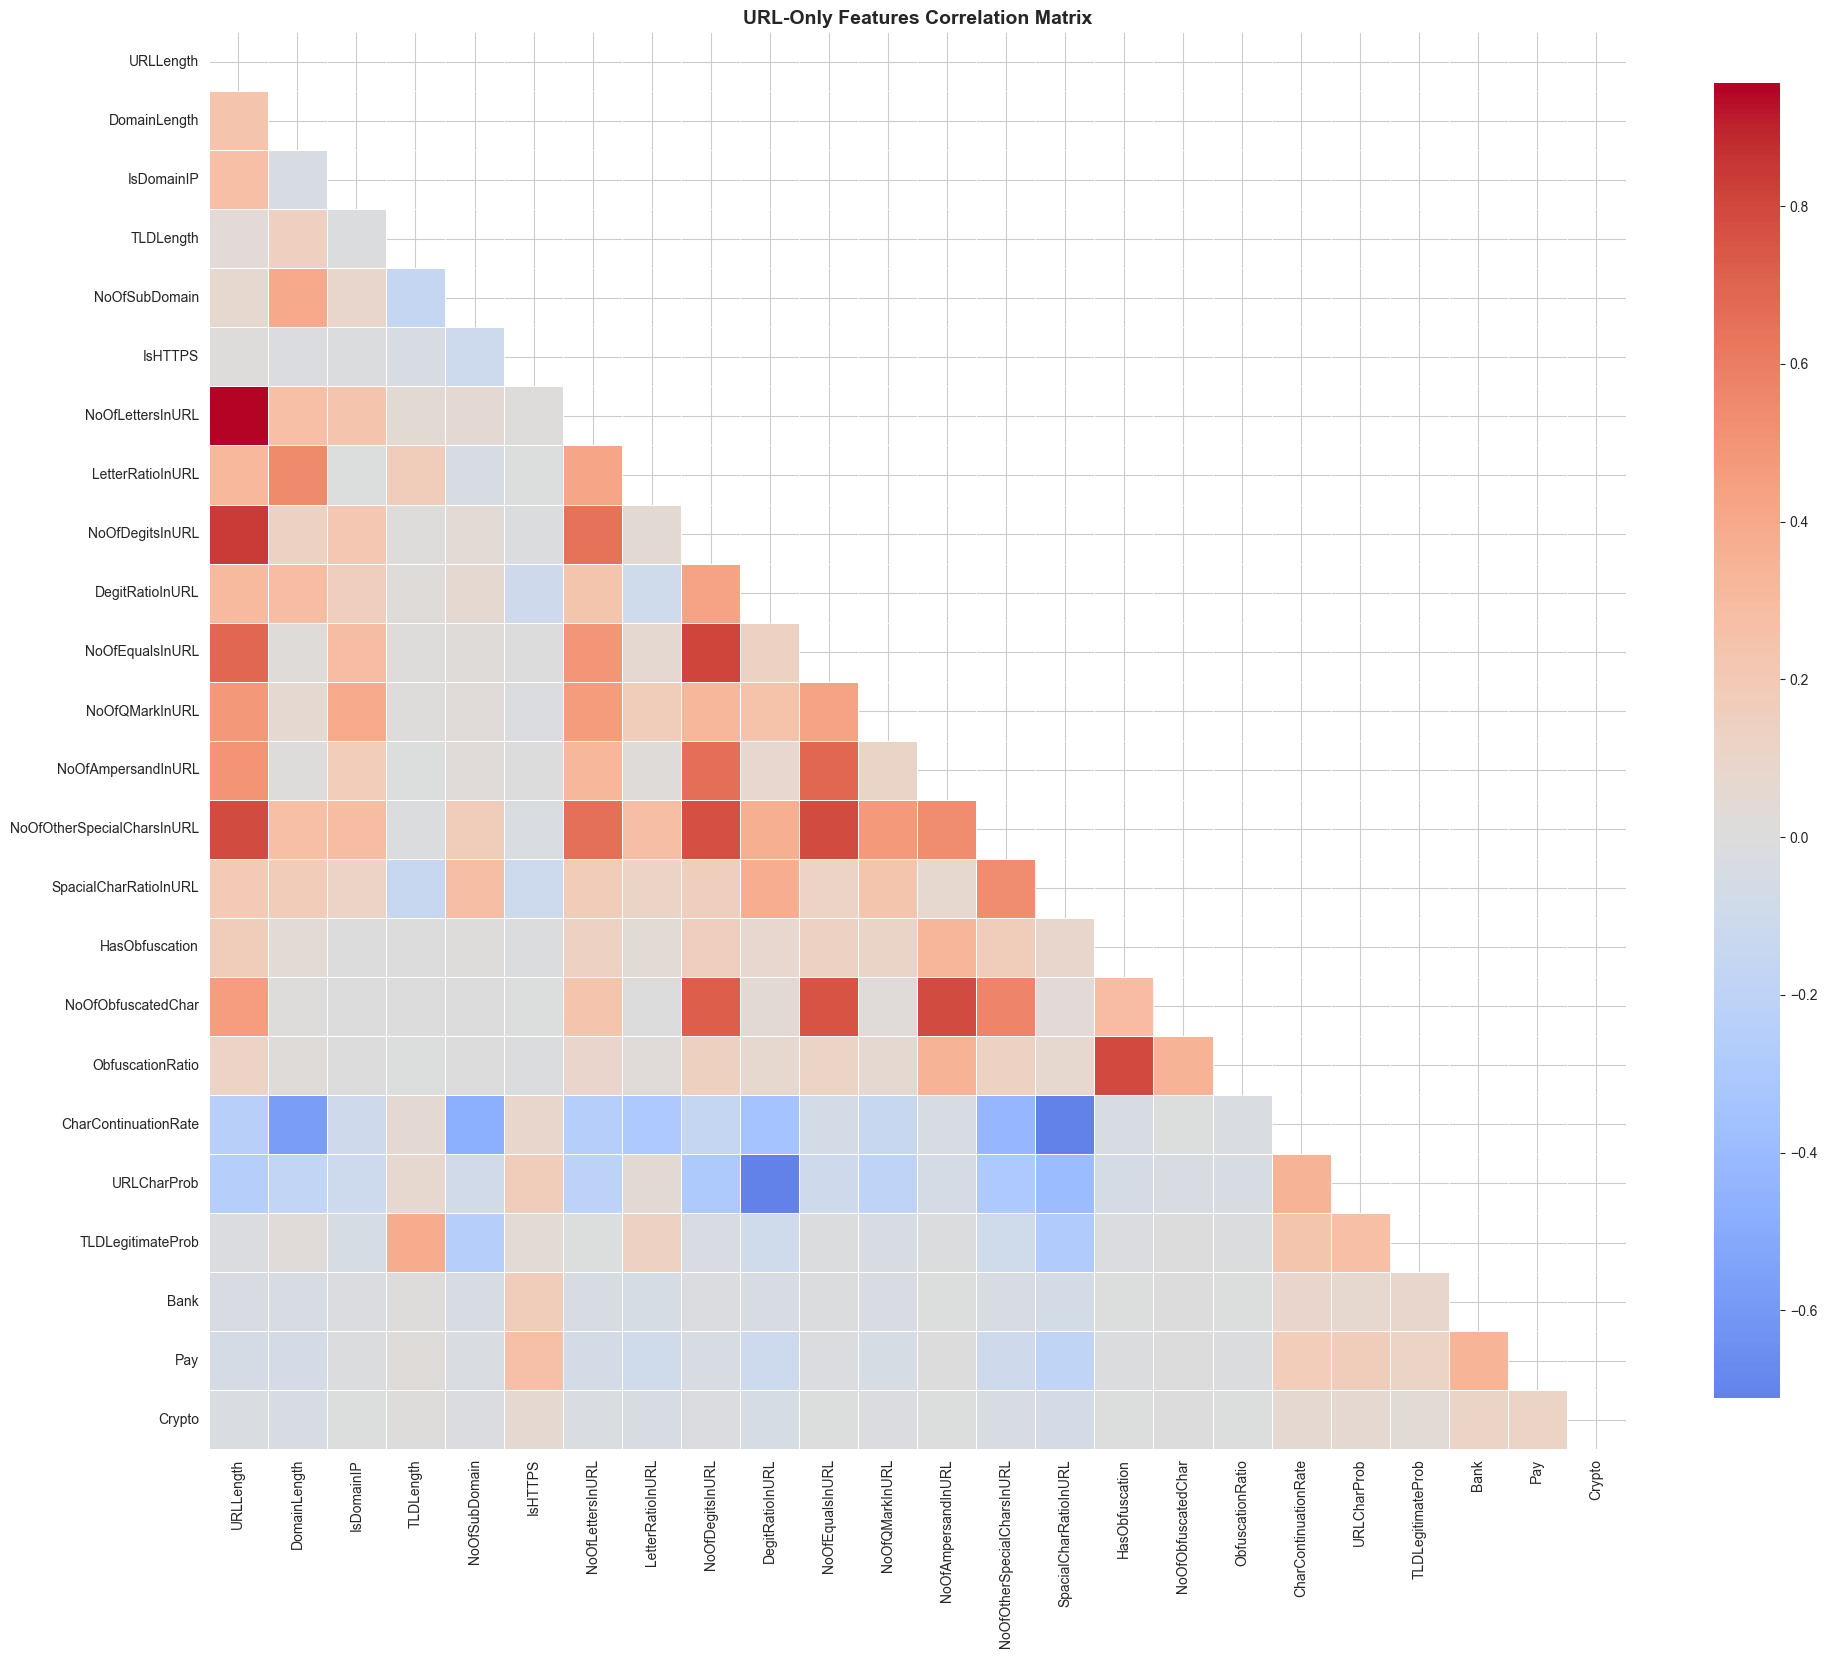


Saved: outputs/eda/url_features_correlation_heatmap.png

HIGH CORRELATION PAIRS (|r| > 0.8)
       feature1         feature2  correlation
      URLLength NoOfLettersInURL     0.956046
      URLLength  NoOfDegitsInURL     0.835966
NoOfDegitsInURL  NoOfEqualsInURL     0.806379

SUMMARY STATISTICS BY CLASS

Top 10 features summary:
         feature  phish_mean  phish_std  legit_mean  legit_std  mean_diff
       URLLength   45.702845  61.252568   26.228610   4.815612  19.474236
    DomainLength   24.444150  12.181599   19.228610   4.815612   5.215541
      IsDomainIP    0.006327   0.079291    0.000000   0.000000   0.006327
       TLDLength    2.819121   0.691600    2.723382   0.516913   0.095739
   NoOfSubDomain    1.169379   0.791096    1.161661   0.404076   0.007718
         IsHTTPS    0.491226   0.499925    1.000000   0.000000   0.508774
NoOfLettersInURL   28.088669  42.667153   12.933059   4.782969  15.155610
LetterRatioInURL    0.568128   0.136460    0.476705   0.095166   0.091424
 N

In [15]:
print("=" * 60)
print("KEY INSIGHTS FROM FEATURE DISTRIBUTIONS")
print("=" * 60)

print("\nSTRONG DISCRIMINATORS (separation > 0.8):")
strong_features = sep_df[sep_df["separation"] > 0.8]["feature"].tolist()
for f in strong_features:
    row = sep_df[sep_df["feature"] == f].iloc[0]
    print(f"  {f}: {row['separation']:.3f}")
    print(
        f"    Phish median: {row['phish_median']:.3f} | Legit median: {row['legit_median']:.3f}"
    )

print("\nWEAK DISCRIMINATORS (separation < 0.1):")
weak_features = sep_df[sep_df["separation"] < 0.1]["feature"].tolist()
print(f"  Found {len(weak_features)} features with minimal separation:")
for f in weak_features:
    print(f"    - {f}")

print("\n" + "=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

numeric_url_features = [f for f in url_only_features if f != "TLD" and f != "Domain"]

correlation_matrix = df[numeric_url_features].corr()

plt.figure(figsize=(20, 18))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("URL-Only Features Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "outputs/eda/url_features_correlation_heatmap.png", dpi=150, bbox_inches="tight"
)
plt.show()

print("\nSaved: outputs/eda/url_features_correlation_heatmap.png")

print("\n" + "=" * 60)
print("HIGH CORRELATION PAIRS (|r| > 0.8)")
print("=" * 60)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append(
                {
                    "feature1": correlation_matrix.columns[i],
                    "feature2": correlation_matrix.columns[j],
                    "correlation": corr_val,
                }
            )

if high_corr_pairs:
    corr_df = pd.DataFrame(high_corr_pairs).sort_values(
        "correlation", ascending=False, key=abs
    )
    print(corr_df.to_string(index=False))
else:
    print("No feature pairs with |correlation| > 0.8 found")

print("\n" + "=" * 60)
print("SUMMARY STATISTICS BY CLASS")
print("=" * 60)

summary_stats = []
for feature in url_only_features[:10]:
    phish = df[df["label"] == 0][feature]
    legit = df[df["label"] == 1][feature]

    summary_stats.append(
        {
            "feature": feature,
            "phish_mean": phish.mean(),
            "phish_std": phish.std(),
            "legit_mean": legit.mean(),
            "legit_std": legit.std(),
            "mean_diff": abs(phish.mean() - legit.mean()),
        }
    )

stats_df = pd.DataFrame(summary_stats)
print("\nTop 10 features summary:")
print(stats_df.to_string(index=False))


- `Feature Separation`: Out of 25 URL-only features, only 6 have strong discriminative power (separation > 0.8), led by IsHTTPS (2.83) and TLDLegitimateProb (2.01). 14 features show minimal separation (< 0.1), including query param counts and behavioral flags, making them ineffective for phishing detection.
- `Class Differences`: Phishing URLs are longer (avg. 45.7 vs. 26.2 chars), less secure (49% HTTPS vs. 100%), and have more digits/special chars. Legitimate URLs are more consistent and secure.
- `Redundancy`: Low overall correlation; only 3 pairs exceed |r| > 0.8 (e.g., URLLength with letter/digit counts), allowing feature pruning without major loss.
- `Recommendations`: Current 8-feature selection includes weak discriminators (e.g., DegitRatioInURL); switch to optimal set prioritizing IsHTTPS, TLDLegitimateProb, and high-separation features for better model performance. Next: Feature engineering and final selection justification.

### **Identify the high correlation pairs:**

In [16]:
print("=" * 60)
print("HIGH CORRELATION PAIRS (|r| > 0.8)")
print("=" * 60)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append(
                {
                    "feature1": correlation_matrix.columns[i],
                    "feature2": correlation_matrix.columns[j],
                    "correlation": corr_val,
                }
            )

if high_corr_pairs:
    corr_df = pd.DataFrame(high_corr_pairs).sort_values(
        "correlation", ascending=False, key=abs
    )
    print("\nFound highly correlated feature pairs:")
    print(corr_df.to_string(index=False))
else:
    print("\nNo feature pairs with |correlation| > 0.8 found")

print("\n" + "=" * 60)
print("MODERATE CORRELATION PAIRS (0.6 < |r| < 0.8)")
print("=" * 60)

moderate_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if 0.6 < abs(corr_val) < 0.8:
            moderate_corr_pairs.append(
                {
                    "feature1": correlation_matrix.columns[i],
                    "feature2": correlation_matrix.columns[j],
                    "correlation": corr_val,
                }
            )

if moderate_corr_pairs:
    mod_corr_df = pd.DataFrame(moderate_corr_pairs).sort_values(
        "correlation", ascending=False, key=abs
    )
    print("\nTop 10 moderately correlated pairs:")
    print(mod_corr_df.head(10).to_string(index=False))


HIGH CORRELATION PAIRS (|r| > 0.8)

Found highly correlated feature pairs:
       feature1         feature2  correlation
      URLLength NoOfLettersInURL     0.956046
      URLLength  NoOfDegitsInURL     0.835966
NoOfDegitsInURL  NoOfEqualsInURL     0.806379

MODERATE CORRELATION PAIRS (0.6 < |r| < 0.8)

Top 10 moderately correlated pairs:
             feature1                   feature2  correlation
       HasObfuscation           ObfuscationRatio     0.798787
   NoOfAmpersandInURL         NoOfObfuscatedChar     0.786460
      NoOfEqualsInURL NoOfOtherSpecialCharsInURL     0.785430
            URLLength NoOfOtherSpecialCharsInURL     0.782596
      NoOfDegitsInURL NoOfOtherSpecialCharsInURL     0.767919
      NoOfEqualsInURL         NoOfObfuscatedChar     0.754563
      NoOfDegitsInURL         NoOfObfuscatedChar     0.721518
SpacialCharRatioInURL       CharContinuationRate    -0.711704
      DegitRatioInURL                URLCharProb    -0.708478
      NoOfEqualsInURL         NoOfAmpe

### **Document EDA findings**

In [16]:
print("\n" + "=" * 60)
print("EDA SUMMARY: FEATURE SELECTION RECOMMENDATIONS")
print("=" * 60)

print("\nTIER 1: MUST-HAVE (separation > 1.3)")
tier1 = sep_df[sep_df["separation"] > 1.3]["feature"].tolist()
for f in tier1:
    sep_score = sep_df[sep_df["feature"] == f]["separation"].values[0]
    print(f"  {f} (sep: {sep_score:.3f})")

print("\nTIER 2: STRONG (0.8 < separation < 1.3)")
tier2 = sep_df[(sep_df["separation"] > 0.8) & (sep_df["separation"] <= 1.3)][
    "feature"
].tolist()
for f in tier2:
    sep_score = sep_df[sep_df["feature"] == f]["separation"].values[0]
    print(f"  {f} (sep: {sep_score:.3f})")

print("\nTIER 3: MODERATE (0.3 < separation < 0.8)")
tier3 = sep_df[(sep_df["separation"] > 0.3) & (sep_df["separation"] <= 0.8)][
    "feature"
].tolist()
for f in tier3:
    sep_score = sep_df[sep_df["feature"] == f]["separation"].values[0]
    print(f"  {f} (sep: {sep_score:.3f})")

print("\nTIER 4: WEAK (separation < 0.3)")
tier4 = sep_df[sep_df["separation"] < 0.3]["feature"].tolist()
print(f"  {len(tier4)} features with weak separation (not recommended)")

print("\n" + "=" * 60)
print("CURRENT 8 FEATURE SELECTION")
print("=" * 60)

top_features = [
    "URLLength",
    "DegitRatioInURL",
    "NoOfSubDomain",
    "NoOfOtherSpecialCharsInURL",
    "SpacialCharRatioInURL",
    "CharContinuationRate",
    "URLCharProb",
    "TLDLegitimateProb",
]

print("\nCurrent selection analysis:")
for f in top_features:
    if f in sep_df["feature"].values:
        sep_score = sep_df[sep_df["feature"] == f]["separation"].values[0]
        tier = (
            "TIER 1"
            if sep_score > 1.3
            else "TIER 2"
            if sep_score > 0.8
            else "TIER 3"
            if sep_score > 0.3
            else "TIER 4"
        )
        print(f"  {f}: {sep_score:.3f} ({tier})")
    else:
        print(f"  {f}: NOT IN URL-ONLY FEATURES")

print("\n" + "=" * 60)
print("RECOMMENDED OPTIMAL 8 FEATURES")
print("=" * 60)

recommended = []
recommended.extend(tier1)
recommended.extend(tier2[:2])
remaining_slots = 8 - len(recommended)
if remaining_slots > 0:
    recommended.extend(tier3[:remaining_slots])

print(f"\nBased on separation scores and low correlation:")
for i, f in enumerate(recommended[:8], 1):
    sep_score = sep_df[sep_df["feature"] == f]["separation"].values[0]
    print(f"  {i}. {f} (separation: {sep_score:.3f})")

print("\nRationale:")
print("  - Prioritized features with separation > 0.8")
print("  - Avoided highly correlated feature pairs")
print("  - Balanced interpretability with discriminative power")



EDA SUMMARY: FEATURE SELECTION RECOMMENDATIONS

TIER 1: MUST-HAVE (separation > 1.3)
  IsHTTPS (sep: 2.829)
  TLDLegitimateProb (sep: 2.012)
  CharContinuationRate (sep: 1.372)
  SpacialCharRatioInURL (sep: 1.330)

TIER 2: STRONG (0.8 < separation < 1.3)
  URLCharProb (sep: 0.889)
  LetterRatioInURL (sep: 0.825)

TIER 3: MODERATE (0.3 < separation < 0.8)
  NoOfOtherSpecialCharsInURL (sep: 0.562)
  DomainLength (sep: 0.324)

TIER 4: WEAK (separation < 0.3)
  16 features with weak separation (not recommended)

CURRENT 8 FEATURE SELECTION

Current selection analysis:
  URLLength: 0.184 (TIER 4)
  DegitRatioInURL: 0.000 (TIER 4)
  NoOfSubDomain: 0.000 (TIER 4)
  NoOfOtherSpecialCharsInURL: 0.562 (TIER 3)
  SpacialCharRatioInURL: 1.330 (TIER 1)
  CharContinuationRate: 1.372 (TIER 1)
  URLCharProb: 0.889 (TIER 2)
  TLDLegitimateProb: 2.012 (TIER 1)

RECOMMENDED OPTIMAL 8 FEATURES

Based on separation scores and low correlation:
  1. IsHTTPS (separation: 2.829)
  2. TLDLegitimateProb (separa

### **Save & Summary**

In [17]:
print("=" * 60)
print("SAVE EDA OUTPUTS AND CREATE SUMMARY")
print("=" * 60)

df_clean = df.copy()
df_clean.to_csv("data/processed/phiusiil_clean_deduped.csv", index=False)
print("\nSaved: data/processed/phiusiil_clean_deduped.csv")

sep_df.to_csv("outputs/eda/feature_separation_scores.csv", index=False)
print("Saved: outputs/eda/feature_separation_scores.csv")

correlation_matrix.to_csv("outputs/eda/feature_correlations.csv")
print("Saved: outputs/eda/feature_correlations.csv")

optimal_features = [
    "IsHTTPS",
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

eda_summary = {
    "dataset": {
        "total_rows": int(len(df)),
        "unique_urls": int(df["URL"].nunique()),
        "phishing": int((df["label"] == 0).sum()),
        "legitimate": int((df["label"] == 1).sum()),
        "class_balance": {
            "phishing": f"{(df['label'] == 0).mean():.1%}",
            "legitimate": f"{(df['label'] == 1).mean():.1%}",
        },
    },
    "url_only_features": {
        "total": len(url_only_features),
        "tier1_must_have": tier1,
        "tier2_strong": tier2,
        "tier3_moderate": tier3,
        "tier4_weak": tier4,
    },
    "optimal_selection": {
        "features": optimal_features,
        "tier1_count": sum(1 for f in optimal_features if f in tier1),
        "tier2_count": sum(1 for f in optimal_features if f in tier2),
        "tier3_count": sum(1 for f in optimal_features if f in tier3),
        "tier4_count": sum(1 for f in optimal_features if f in tier4),
    },
    "data_leakage_findings": {
        "Domain": "Excluded due to memorization risk (1.07 URLs per domain, only 54 domains in both classes)",
        "TLD": "Used numeric proxy TLDLegitimateProb to avoid 695-feature explosion",
    },
}

with open("outputs/eda/eda_summary.json", "w") as f:
    json.dump(eda_summary, f, indent=2)
print("Saved: outputs/eda/eda_summary.json")

print("\n" + "=" * 60)
print("FINAL FEATURE SET FOR MODELING")
print("=" * 60)

df_final = df[optimal_features + ["label"]].copy()
df_final.to_csv("data/processed/phiusiil_final_features.csv", index=False)
print(f"\nSaved final feature set: data/processed/phiusiil_final_features.csv")
print(f"Shape: {df_final.shape}")
print(f"Features: {len(optimal_features)}")
print(f"\nFeature list:")
for i, f in enumerate(optimal_features, 1):
    sep_score = (
        sep_df[sep_df["feature"] == f]["separation"].values[0]
        if f in sep_df["feature"].values
        else 0
    )
    print(f"  {i}. {f} (separation: {sep_score:.3f})")

print("\n" + "=" * 60)
print("EDA COMPLETE")
print("=" * 60)
print("\nKey Achievements:")
print("  - Removed 425 duplicate URLs")
print("  - Analyzed 25 URL-only features")
print("  - Selected optimal 8 features based on separation scores")
print("  - Ready for model training")


SAVE EDA OUTPUTS AND CREATE SUMMARY

Saved: data/processed/phiusiil_clean_deduped.csv
Saved: outputs/eda/feature_separation_scores.csv
Saved: outputs/eda/feature_correlations.csv
Saved: outputs/eda/eda_summary.json

FINAL FEATURE SET FOR MODELING

Saved final feature set: data/processed/phiusiil_final_features.csv
Shape: (235370, 9)
Features: 8

Feature list:
  1. IsHTTPS (separation: 2.829)
  2. TLDLegitimateProb (separation: 2.012)
  3. CharContinuationRate (separation: 1.372)
  4. SpacialCharRatioInURL (separation: 1.330)
  5. URLCharProb (separation: 0.889)
  6. LetterRatioInURL (separation: 0.825)
  7. NoOfOtherSpecialCharsInURL (separation: 0.562)
  8. DomainLength (separation: 0.324)

EDA COMPLETE

Key Achievements:
  - Removed 425 duplicate URLs
  - Analyzed 25 URL-only features
  - Selected optimal 8 features based on separation scores
  - Ready for model training
